In [1]:
!pip install -r requirements.txt --quiet --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.2 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.0.0 which is incompatible.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import time
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.rcParams['figure.figsize'] =  (22,5)
plt.rcParams['font.size'] = 14

In [3]:
symbol = 'GOOGL'
df = yf.Ticker(symbol).history(period='max').reset_index()
df['Date'] = df['Date'].dt.date
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2004-08-19,2.499634,2.601119,2.398648,2.508132,893181924,0.0,0.0
1,2004-08-20,2.524880,2.726600,2.512132,2.707353,456686856,0.0,0.0
2,2004-08-23,2.768345,2.836584,2.725851,2.734599,365122512,0.0,0.0
3,2004-08-24,2.780593,2.789591,2.588871,2.621365,304946748,0.0,0.0
4,2004-08-25,2.623616,2.699605,2.596620,2.649612,183772044,0.0,0.0


In [5]:
df.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
dtype: object

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,5007,2014-07-29 06:04:05.895746048,2004-08-19 00:00:00,2009-08-08 12:00:00,2014-07-30 00:00:00,2019-07-20 12:00:00,2024-07-11 00:00:00,NaN
Open,5007.0,44.905615,2.479387,13.054337,27.517917,60.183928,190.309998,42.429791
High,5007.0,45.376735,2.543127,13.185068,27.732671,60.674615,191.75,42.900396
Low,5007.0,44.444759,2.398648,12.913108,27.268704,59.823592,189.029999,42.00148
Close,5007.0,44.924563,2.499884,13.060586,27.469973,60.305786,191.179993,42.470622
Volume,5007.0,117732528.987018,9312000.0,31104600.0,60271668.0,142367490.0,1643023332.0,148028265.05471
Dividends,5007.0,0.00004,0.0,0.0,0.0,0.0,0.2,0.002826
Stock Splits,5007.0,0.004393,0.0,0.0,0.0,0.0,20.0,0.284046


In [7]:
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')

The data has 5007 rows and 8 columns


Lets look at the movement of Various figures (Open, High, Low, Close) over the months

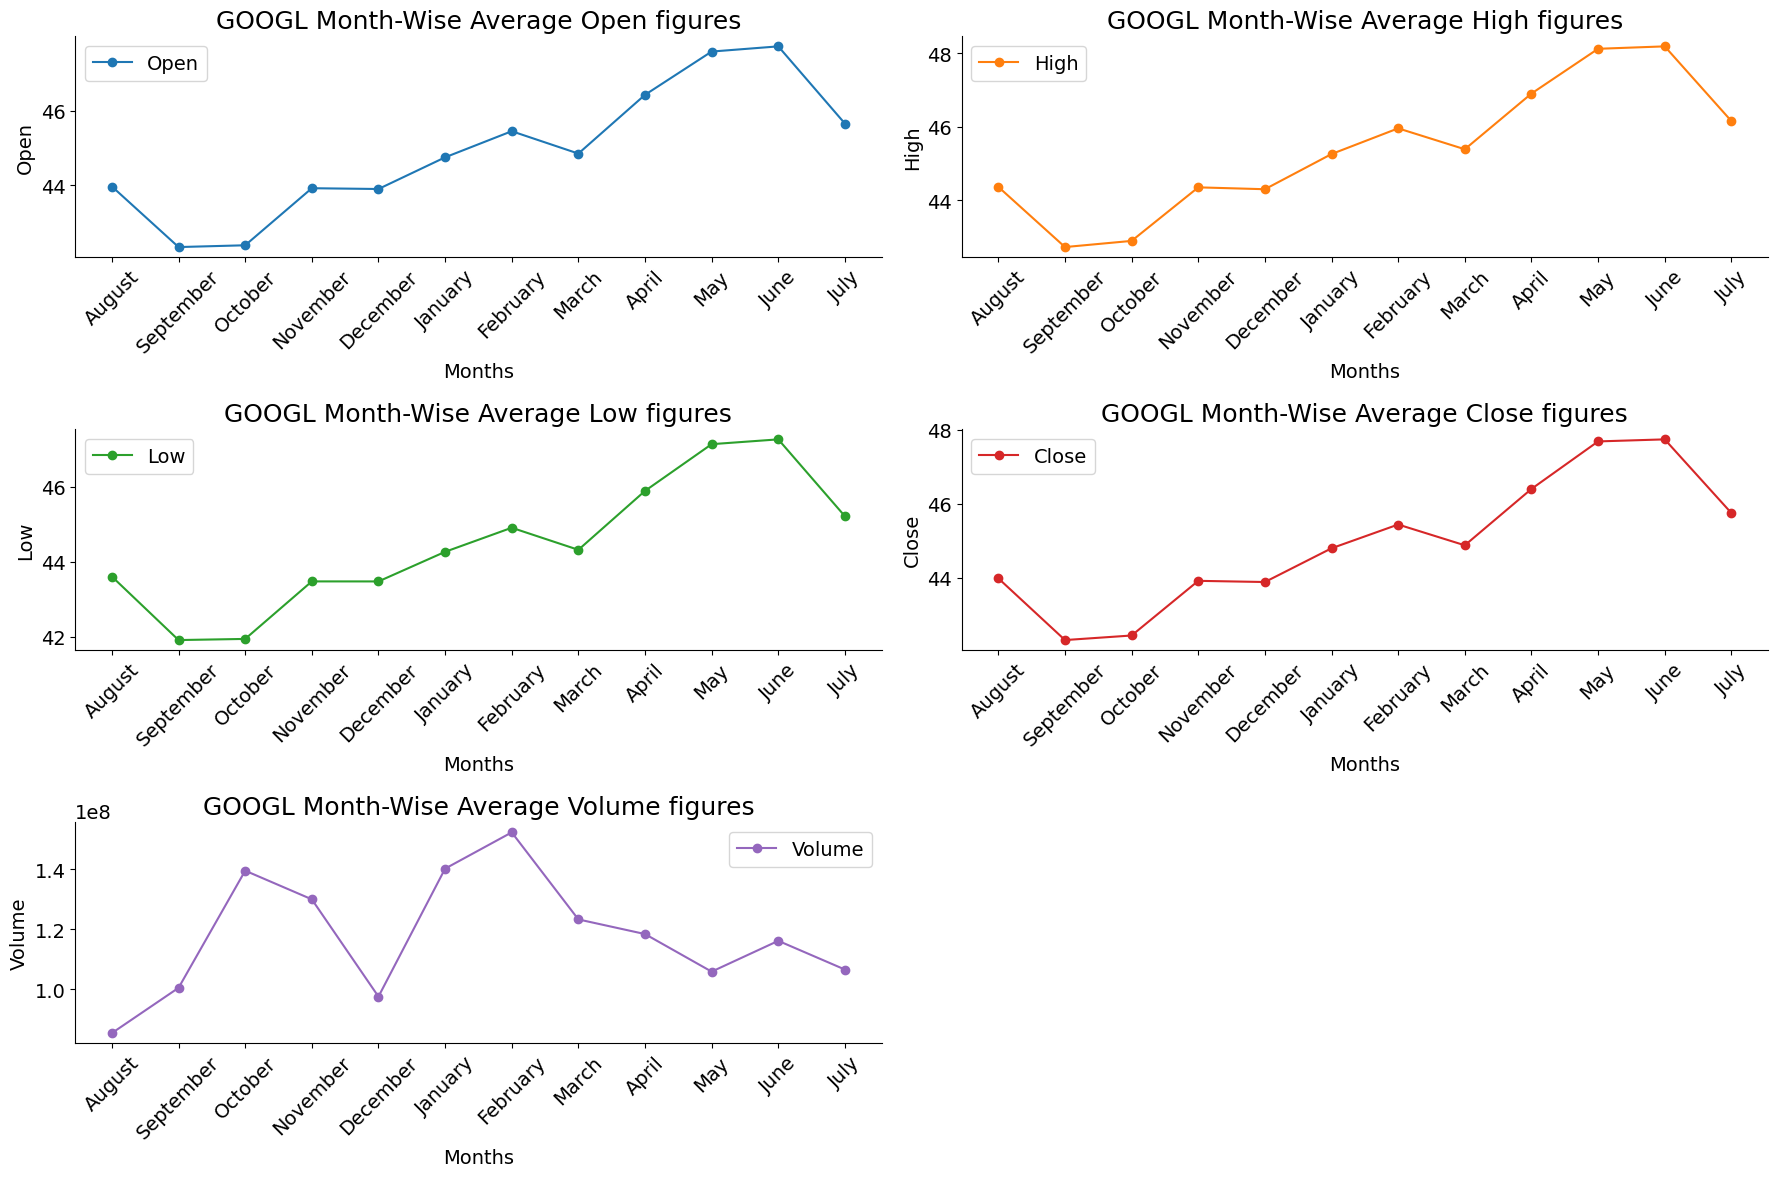

In [8]:
colors = plt.rcParams["axes.prop_cycle"]()
a = 3  # number of rows
b = 2  # number of columns
c = 1  # initialize plot df

#Set the figure size of the plot
fig = plt.figure(figsize=(18,12))

n = len(df.groupby(df['Date'].dt.month_name(), sort=False).mean().columns[1:-2])

#Loop through the each column in the dataframe to generate a subplot
for i in range(1,n+1):
    color = next(colors)["color"]
    #Generate a subplot with the given dimensions
    plt.subplot(a, b, c)
    #Plot the data in a line graph, with different colors for each line
    plt.plot(df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i], color= color, marker='o')
    #Remove the top and right borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #Rotate the x-tick labels by 45 degrees
    plt.xticks(rotation=45)
    #Set the title, x-axis label, y-axis label, and legend
    plt.title(f"{symbol} Month-Wise Average {df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name} figures", fontsize=18)
    plt.xlabel('Months')
    plt.ylabel(df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name)
    plt.legend([df.groupby(df['Date'].dt.month_name(), sort=False).mean().iloc[:, i].name])
    #Increment the subplot df
    c = c + 1

#Adjust the layout of the plot
plt.tight_layout()
#Show the plot
plt.show()

**INSIGHTS**

- Open, High, Low and close figures reach the maximum values around June month.
- Volume Avge Figures reach the max figures between January and February.

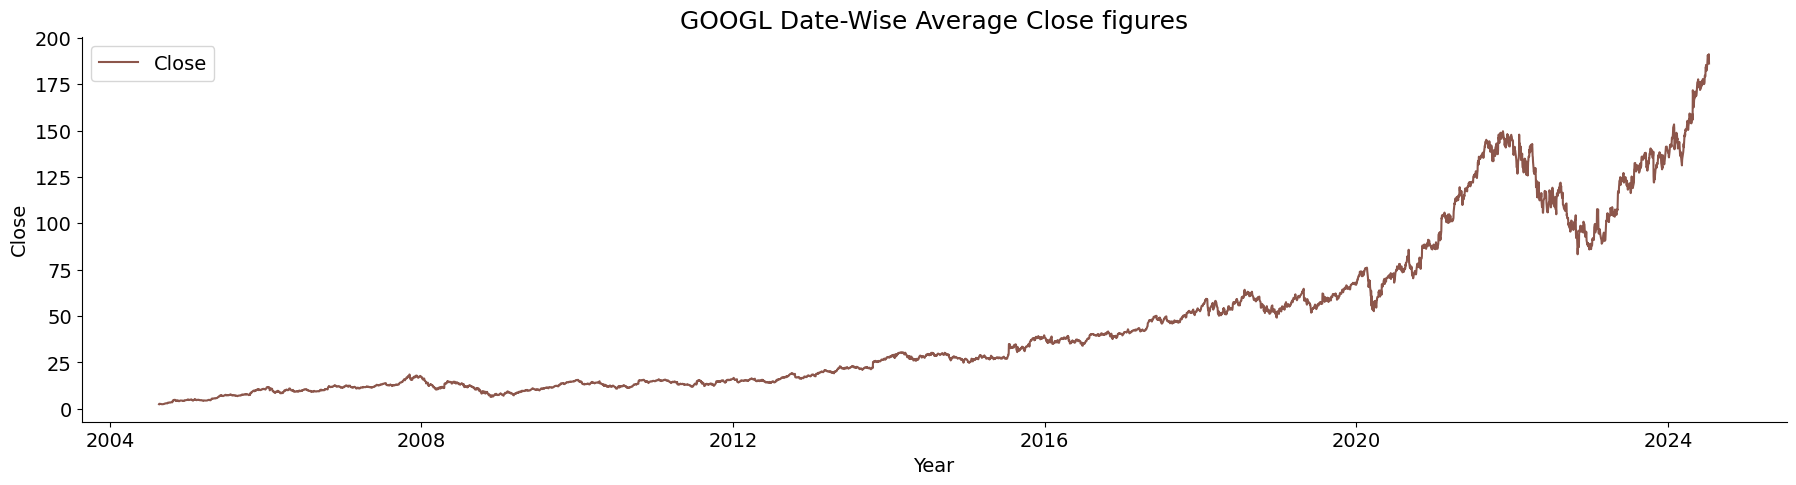

In [9]:
plt.plot(df.groupby(df['Date'], sort=False).mean().Close, color= next(colors)["color"])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.title(f"{symbol} Date-Wise Average Close figures", fontsize=18)
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend(['Close'])
plt.show()

**INSIGHTS**

- There is an upward trend in the price of Google which is definitely a good sign for the company and it's shareholders.

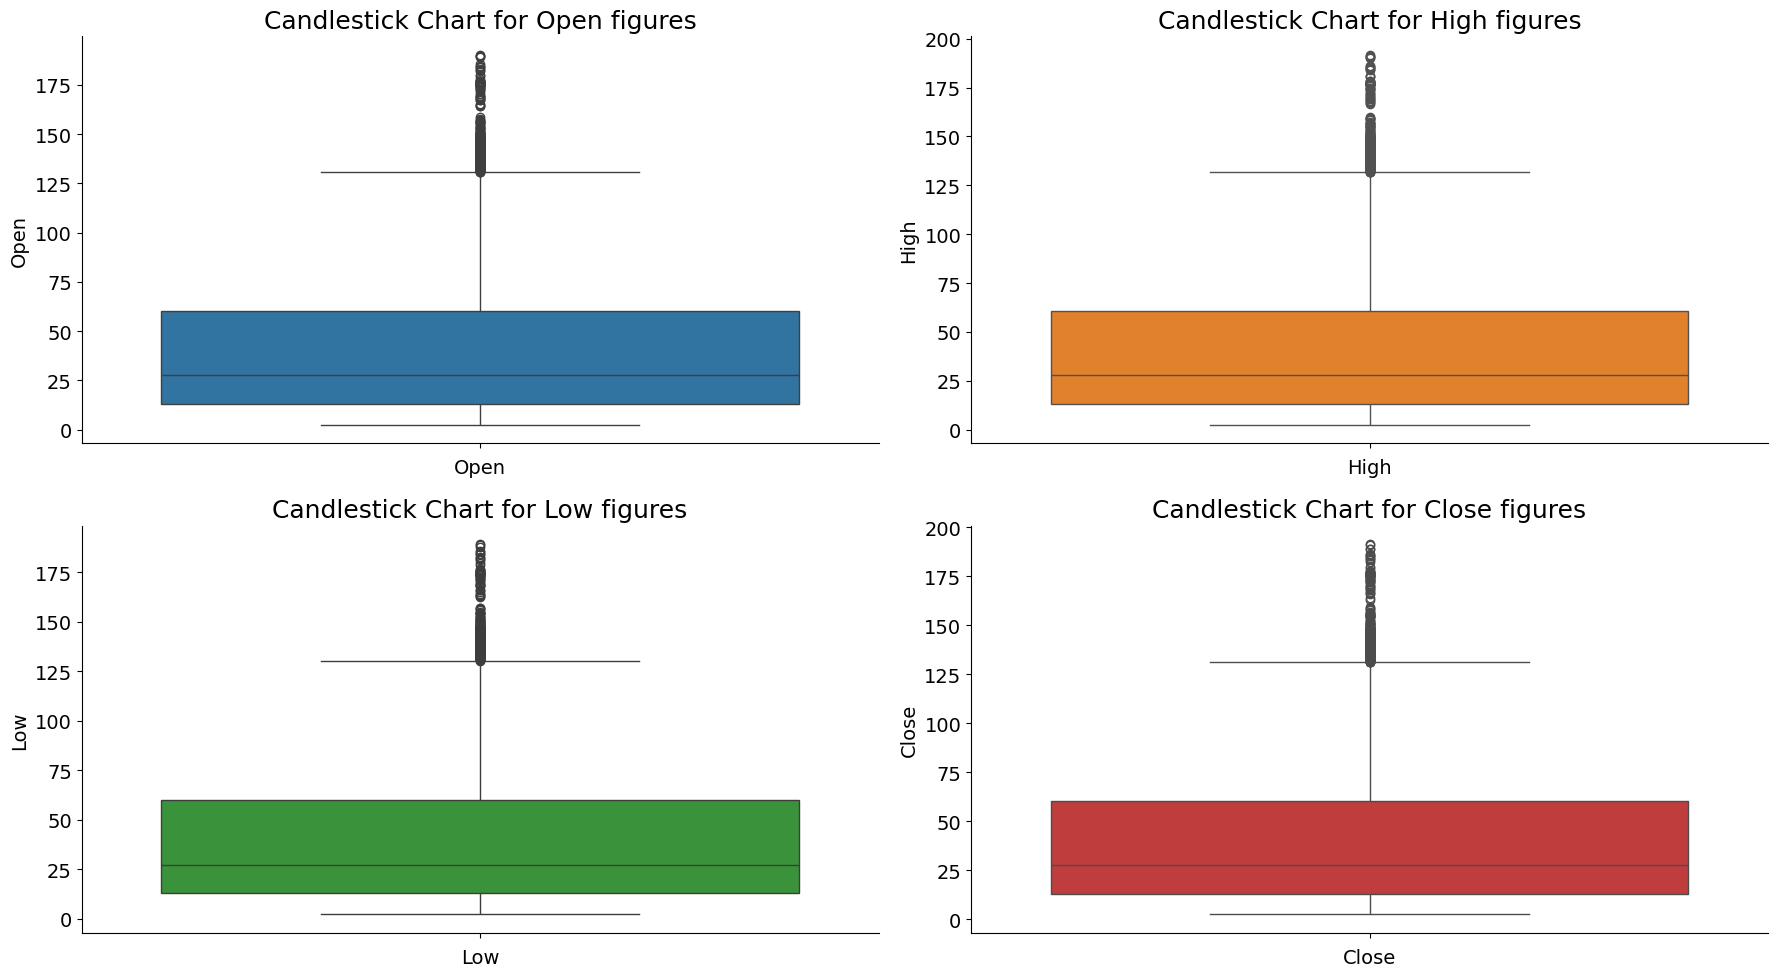

In [10]:
# This code plots boxplots of various columns in a dataframe, data_hist.

colors = plt.rcParams["axes.prop_cycle"]()

# The number of rows, columns, and the subplot counter are initialized. 
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

# A figure is initialized  
fig = plt.figure(figsize=(18,10))

length = range(1,len(df.columns[:-3]))

#loop is used to iterate over the columns of dataframe. 
for i in length:
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    #For each column, a boxplot is plotted and labels and titles are set accordingly. 
    sns.boxplot(df[df.columns[i]], color= color )
    # The spines of each plot are made invisible and the figure is adjusted and shown.
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #X Axis label is added
    plt.xlabel(df.columns[i])
    #title to the plot is added
    plt.title(f'Candlestick Chart for {df.columns[i]} figures', fontsize=18)
    c = c + 1

#Layout is tightended up
plt.tight_layout()

#plot is displayed
plt.show()

## ARMA 


### Auto-Regressive (AR)

- A Statistical model that tries to predict the values based on lagged values and the lag could be chosen as per the wish.

- The AR part of the model involves regressing the variable on its own lagged (past) values. The order of the AR part is denoted by `p`

- **For Example**: Sales of 9th month could be predicted based on 7th and 8th Month.


The AR part of the model is calculated by the below formula:-

**Formula:**
$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_3 X_{t-3} + \cdots + \phi_p X_{t-p} + \epsilon_t $$

Where:
- $ X_t $ is the value of the series at time $ t $.
- $ c $ is the constant term (intercept).
- $ \phi_i $ (for $ i = 1, 2, \ldots, p $) are the coefficients (calculated using OLS method) of the lagged values.
- $ X_{t-i} $ are the lagged values of the series.
- $ \epsilon_t $ is the error term (white noise) at time $ t $.


For example, for an AR(2) model (where $ p = 2 $), the equation would be:

$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \epsilon_t $$

This explicitly shows that $ X_t $ depends on the two most recent past values of the series, $ X_{t-1} $ and $ X_{t-2} $. Similarly, for an AR(n) model (where p = infinity ), the equation would be:

$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ..... + \phi_n X_{t-n}\epsilon_t $$

In [11]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2004-08-19,2.499634,2.601119,2.398648,2.508132,893181924,0.0,0.0
1,2004-08-20,2.524880,2.726600,2.512132,2.707353,456686856,0.0,0.0
2,2004-08-23,2.768345,2.836584,2.725851,2.734599,365122512,0.0,0.0
3,2004-08-24,2.780593,2.789591,2.588871,2.621365,304946748,0.0,0.0
4,2004-08-25,2.623616,2.699605,2.596620,2.649612,183772044,0.0,0.0


In [12]:
#shifting the data by 1 and 2 rows, shifting would mean pushing the data n rows forward
df['Close_Lag_1'], df['Close_Lag_2'] = df['Close'].shift(1), df['Close'].shift(2)

#Dropping the rows where the values are NaN because they couldn't be filled when shifted by 1 or 2 rows
df.dropna(inplace=True)

#create a new df with the original series, 1 lagged and 2 lagged values
df_lagged = df[['Close','Close_Lag_1', 'Close_Lag_2']]

X = df_lagged[['Close_Lag_1', 'Close_Lag_2']]
X['Intercept'] = 1
y = df_lagged['Close']

# Use numpy's least squares to estimate parameters
params = np.linalg.lstsq(X, y, rcond=None)[0]
phi_1, phi_2, c = params[0], params[1], params[2]

print(f"Estimated parameters: c = {c:.4f}, phi_1 = {phi_1:.4f}, phi_2 = {phi_2:.4f}")

# Step 4: Predict future values
def predict_ar2(X_t_minus_1, X_t_minus_2, c, phi_1, phi_2):
    return c + phi_1 * X_t_minus_1 + phi_2 * X_t_minus_2

# Predict the next value in the series
X_t_minus_1 = df['Close'].iloc[-3]
X_t_minus_2 = df['Close'].iloc[-2]
X_t_pred = predict_ar2(X_t_minus_1, X_t_minus_2, c, phi_1, phi_2)

print("Predicted next value: X_t_pred" , round(X_t_pred,4))

Estimated parameters: c = 0.0059, phi_1 = 0.9440, phi_2 = 0.0567
Predicted next value: X_t_pred 189.2491


In [13]:
#Coefficient for lags (first 2, third is constant term) calculated using ordinary least squares implemented in Numpy
params

array([0.94400885, 0.05672338, 0.00591767])

So the values here 0.94590329, 0.0548866 are the coefficient of lags (2 here) which then gets multiplied by the lagged value of the series and gets summed up (add an random error too) to get the value at the current time stamp.

### Does Changing the Lag Order in the AR Model affect the results?

Yes, changing the order of the lags in the autoregressive model equation will impact the final result. This is because the coefficients $ \phi_i $ in an AR model are specifically tied to particular lagged values of the time series, representing their respective influences on the current value $ X_t $. 

In an AR(p) model, each coefficient $ \phi_i $ is associated with a specific lag. The model captures the relationship between $ X_t $ and its past values:

$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \cdots + \phi_p X_{t-p} + \epsilon_t $$

If you change the order of the lags, such as $ X_t = c + \phi_1 X_{t-2} + \phi_2 X_{t-3} + \phi_3 X_{t-1} + \cdots + \phi_p X_{t-p} + \epsilon_t $ you are altering which lagged value is associated with which coefficient. This means:

1. **Different Relationships**: The model will now capture different relationships between $ X_t $ and its past values. For example, $ \phi_1 $ will now be the coefficient for $ X_{t-2} $ instead of $ X_{t-1} $.
2. **Estimation Changes**: When you estimate the parameters using a method like ordinary least squares, the estimated coefficients will change because the input data (lagged values) for each coefficient has changed.
3. **Prediction Impact**: The predictive capability of the model will be different because the model is now using different past values to make predictions about the future.

Talking about the lags, there are 2 functions that we should discuss at this point in time which are ACF and PACF.

## Autocorrelation Function (ACF)

### What is ACF?

<text style="background-color: yellow;" > The Autocorrelation Function (ACF) helps us understand how current values of a time series are related to its past values. Think of it as a measure of how much past values influence the current value. ACF will consider other lags as well while defining the relationship between two lags say, 1st and 4th lag which means 2nd and 3rd lag are also going to get reeled in while determing the relationship between these 2 (1st and 4th) lags. <text>

### Why is ACF Important?

- It helps us identify patterns in the data.
- It’s used to determine the number of Moving Average (MA) `q` terms in an ARIMA model.

### Example

Imagine you have a series of daily temperatures. The ACF will tell you if today’s temperature is related to yesterday’s temperature, the temperature two days ago, and so on.

### How to Read an ACF Plot

- The x-axis represents the lag (how far back you look).
- The y-axis represents the correlation (how strong the relationship is).
- A significant spike at lag k suggests that the value k days ago has a strong relationship with today’s value.

In [14]:
from statsmodels.tsa.stattools import acf
acf_values = acf(df['Close'], nlags=len(df['Close'])-1)

# Print ACF values
print("ACF Values:", acf_values)

ACF Values: [ 1.00000000e+00  9.98437903e-01  9.96835802e-01 ... -2.02103836e-03
 -1.34610156e-03 -6.60497831e-04]


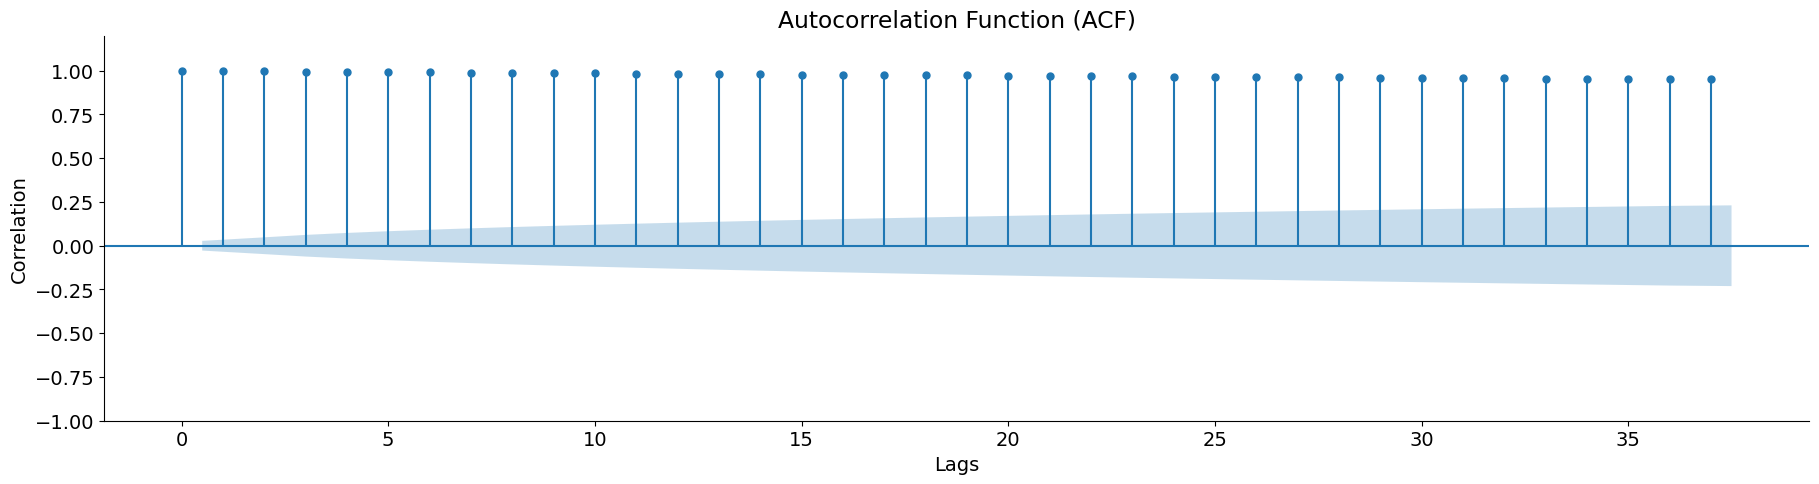

In [15]:
plot_acf(df['Close']) #acf tells q (MA)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation Function (ACF)')
plt.ylim(top=1.2)
plt.show()

<text style="background-color: yellow;"> We see in the ACF plot above that all the lagged value seem to be strongly correlated with other lags. If the ACF values remain close to 1 for all lags, it suggests that there is a strong persistence in the series. This pattern is unusual for a typical Moving Average (MA) process, where we usually expect the ACF to drop off after a certain number of lags. <text>

### Possible Interpretations:

1. **Non-Stationary Series:** ACF values close to 1 at all lags usually indicate a non-stationary series. Non-stationary series have trends or other structures that cause the high correlations at different lags. In such cases, differencing the series might be necessary to achieve stationarity before determining the MA order.

2. **ARIMA Model:** If the series is non-stationary, you might need to fit an ARIMA model instead of just an MA model. The `I` (Integrated) part of ARIMA accounts for differencing to make the series stationary.

### Steps to Address the Issue:

1. **Check for Stationarity:**
   - Perform a stationarity test such as the Augmented Dickey-Fuller (ADF) test.
   - Plot the time series to visually inspect for trends.

2. **Differencing:**
   - If the series is non-stationary, apply differencing (e.g., first difference) and then re-calculate the ACF.

3. **Re-evaluate the ACF:**
   - After differencing, plot the ACF again to determine if the series is now stationary and the ACF shows a meaningful cut-off for determining $q$.


### Determining $q$:

After differencing, the ACF of the differenced series should ideally show a clear pattern where the correlations drop off after a certain lag. The lag at which the ACF first becomes zero (or close to zero) and stays there can help determine the order $q$ for the MA part of the ARIMA model.

If the ACF values after differencing show a sharp cut-off, that cut-off point is your $q$. If the ACF values still do not show a clear cut-off, you may need to investigate further or consider other aspects of the series, such as seasonality or more complex model structures.

So now lets get the differenced series and what is the lag that should be used for `q` values for the MA Model.

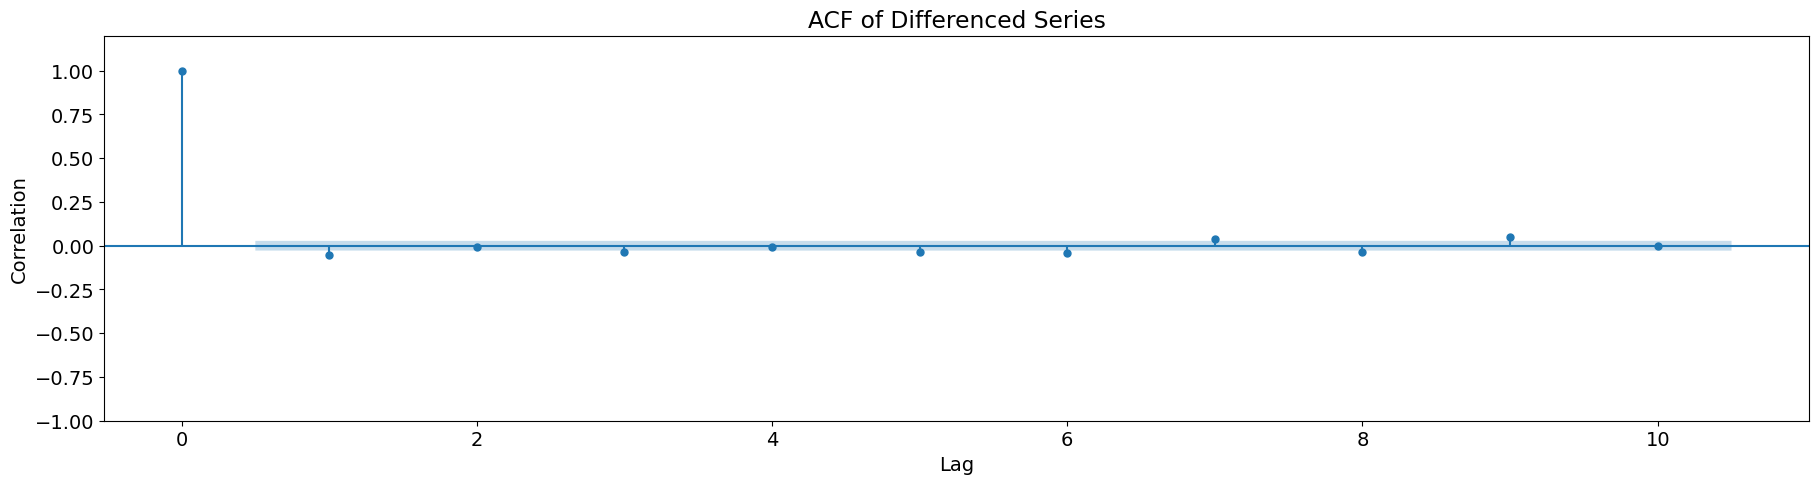

In [16]:
# If non-stationary, apply differencing
differenced_series = np.diff(df['Close'], n=1)

# Plot ACF of differenced series
plot_acf(differenced_series, lags=10)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('ACF of Differenced Series')
plt.ylim(top=1.2)
plt.show()

<text style="background-color: yellow;"> So now we can see that after differencing the series once, we can easily decide on the number of lags (q value) to use for the Moving Average (MA) model. <text>

When we difference our series, the ACF (Autocorrelation Function) plot helps us see if the series is now stationary. If the ACF plot shows a spike at lag 0 (with a correlation of 1) and all other lags are insignificant, it means that differencing has successfully removed the non-stationarity.

### Understanding the ACF Plot After Differencing:

1. **Lag 0 Correlation:** A spike at lag 0 with a correlation of 1 is normal. It shows that the differenced series is perfectly correlated with itself at lag 0.
2. **Insignificant Correlations at Other Lags:** If other lags have insignificant correlations (i.e., they fall within the confidence interval), it means there's no significant autocorrelation at those lags. This suggests the differenced series is stationary.

### Deciding on $q$ for the MA Model:

If the ACF plot of the differenced series shows no significant spikes beyond lag 0, it suggests that we might not need an MA component, or the MA order (q) could be very small, potentially zero.

In other words, if there are no significant autocorrelations in the differenced series, a Moving Average (MA) model with q = 0 might be enough. However, it's usually a good idea to check other diagnostics and use criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to confirm the best model order.

### Next Steps:

1. **Fit an ARIMA Model:** Since there are no significant autocorrelations, you can start with a low q value, like q = 0, and see how well the model fits.
2. **Use Model Selection Criteria:** Use AIC or BIC to compare different models and choose the best one.
3. **Model Diagnostics:** Check the residuals (errors) of the fitted model to ensure they look like random noise.

### Adjusting $p$, $d$, $q$:

- **$p$:** Number of autoregressive terms (how many past values to use).
- **$d$:** Number of times you differenced the series to make it stationary.
- **$q$:** Number of lagged forecast errors in the prediction equation.

Since your ACF plot of the differenced series shows no significant spikes beyond lag 0, you might start with q = 0. You can then experiment with different values of p and d to find the best model.

## Partial Autocorrelation Function (PACF)

### What is PACF?

<text style="background-color: yellow;">  The Partial Autocorrelation Function (PACF) measures the correlation between the time series and its lagged values, but it removes the effects of the intermediate lags. It’s like filtering out the middle steps to see the direct relationship. For example : if its comparing the 8th and the 11th lag it's not going to consider other lags will define the relationship between these 2 lags only and not considering the effect of the 9th and 10th lag <text>



### Why is PACF Important?

- It helps us determine the number of Autoregressive (AR) `p` terms in an ARIMA model.

**Example** - Using the same daily temperature example, the PACF will show the direct relationship between today’s temperature and the temperature two days ago, without being influenced by yesterday’s temperature.

### How to Read a PACF Plot

- The x-axis represents the lag.
- The y-axis represents the partial correlation.
- A significant spike at lag k suggests that the value k days ago has a direct relationship with today’s value, independent of the values in between.

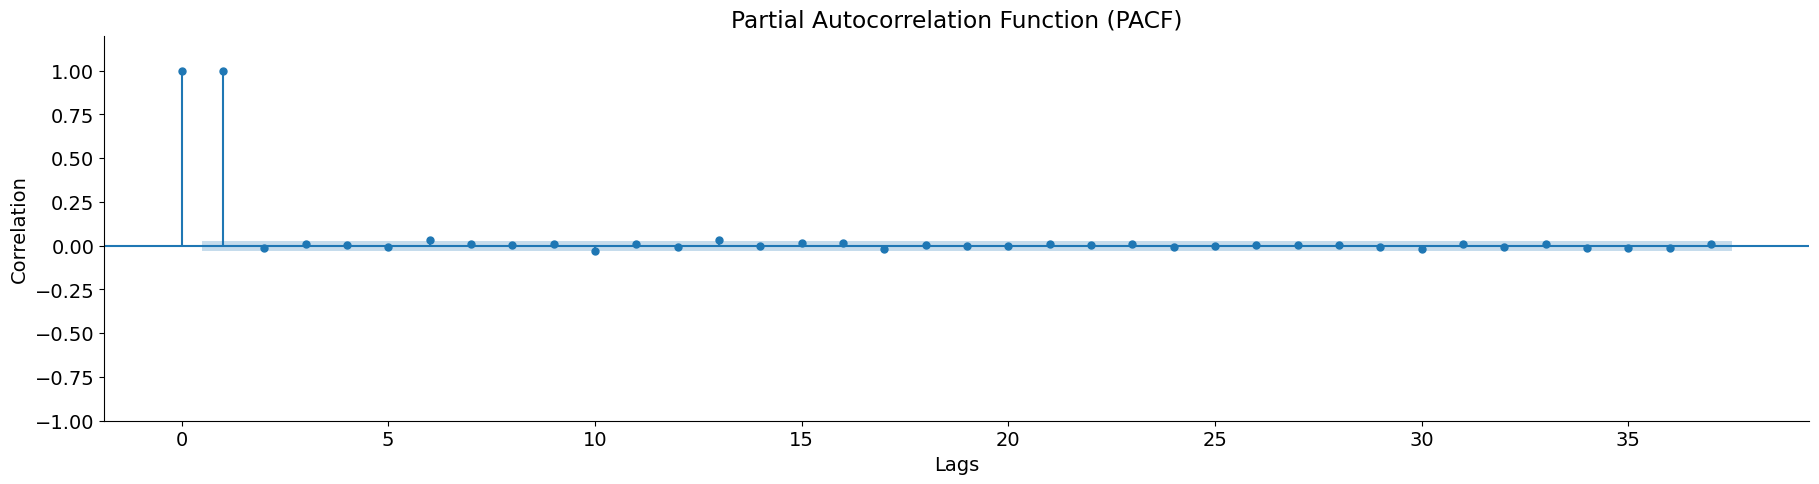

In [17]:
plot_pacf(df['Close']) #pacf tells p (AR)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Rotate the x-tick labels by 45 degrees
plt.xticks(rotation=0)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.ylim(top=1.2)
plt.show()

Now if we were to get the lags here is what we would do:-

1. Take a look at the correlation values. Starting from the left (the value at 0th lag is the orginal series at time t), stop where the correlation value is less than 0.05 (5% significance)
2. In this case the series has a high significance value of the lag at first lag and hence we will take lag = 1
3. We didn't take 2nd lag because its statistically insignificant (less than 0.05 correlation).


*PS : - both the partial autocorrelation function (PACF) and the autocorrelation function (ACF) calculate correlations using the **Pearson correlation coefficient**. This coefficient measures the linear relationship between two variables in a dataset. When applied to time series analysis, it provides valuable insights into the relationship between a variable and its lagged values, aiding in identifying patterns and dependencies within the data.*



## How to Use ACF and PACF for ARMA and ARIMA Modeling

<center> ARMA : <text style="background-color: yellow;"> AR (p) - MA (q) </text> </center>
<center> ARIMA : <text style="background-color: yellow;"> AR (p) - I (d) - MA (q) </text> </center>

1. **Identify AR Order (p)**:
   - Look at the PACF plot.
   - Find where the PACF cuts off (suddenly drops to near zero) – this lag is the AR order (p).

2. **Identify MA Order (q)**:
   - Look at the ACF plot.
   - Find where the ACF cuts off – this lag is the MA order (q).

3. **Identify Differencing Order (d)**:
   - Check if your time series is stationary (its statistical properties do not change over time).
   - If not, determine how many times you need to difference the data to make it stationary.

### Conclusion

- **ACF** helps you see how past values influence the current value.
- **PACF** helps you see the direct relationship between past values and the current value, filtering out the middle steps.
- Together, ACF and PACF help you decide the parameters (p and q) for your ARIMA model.

## Fitting an ARMA Model

So now we have got our `p` and `q` values for the ARMA model let's go ahead and make some predictions to see how close we got with the values we picked out.

However there is something to note here that the statsmodel library has deprecated. As of today, the `statsmodels.tsa.arima_model.ARMA` and `statsmodels.tsa.arima_model.ARIMA` have been removed in favor of `statsmodels.tsa.arima.model.ARIMA` (without _) and `statsmodels.tsa.SARIMAX`.

This is because `statsmodels.tsa.arima.model.ARIMA` makes use of the statespace framework and they're both well tested and maintained. It also offers alternative specialized parameter estimators.

If you try to use ARMA from `statsmodels.tsa.arima_model` you'll get `NotImplementedError` message error so we will just 
import ARIMA from `statsmodels.tsa.arima.model` and use 0 for `d` parameter

In [18]:
exogenous_features = ['Open', 'High', 'Low']
model = ARIMA(df['Close'], order=(1,0,0))
fitted_model = model.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5005
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7747.759
Date:                Fri, 12 Jul 2024   AIC                          15501.518
Time:                        00:19:28   BIC                          15521.073
Sample:                             0   HQIC                         15508.371
                               - 5005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.7435    393.653      0.116      0.907    -725.803     817.290
ar.L1          0.9999      0.000   2318.054      0.000       0.999       1.001
sigma2         1.2922      0.007    179.338      0.000       1.278       1.306
===================================================================================
Ljung-Box (L1) (Q):                  15.01   Jarque-Bera (JB):            117923.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              67.99   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
predictions = fitted_model.predict().to_frame()
predictions['Actual'] = df['Close']
predictions['Date'] = df['Date']
predictions = predictions[['Date', 'Actual', 'predicted_mean']] 
predictions

,Date,Actual,predicted_mean
2,2004-08-23,2.734599,45.743537
3,2004-08-24,2.621365,2.738050
4,2004-08-25,2.649612,2.624825
5,2004-08-26,2.697354,2.653069
6,2004-08-27,2.653361,2.700808
...,...,...,...
5002,2024-07-05,190.600006,185.808770
5003,2024-07-08,189.029999,190.588386
5004,2024-07-09,188.979996,189.018504
5005,2024-07-10,191.179993,188.968505


Now that we have our actual values and the predictions, lets plot them out to see how far off we were. We will make a scatter plot for this.

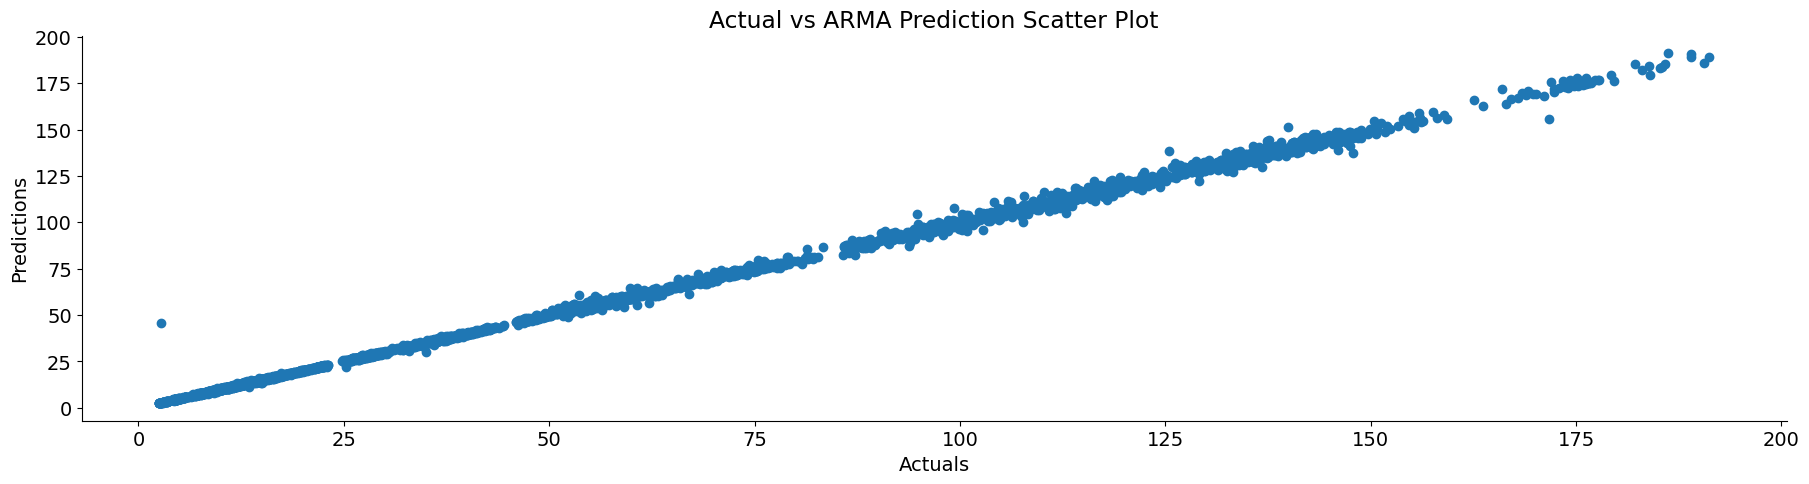

In [21]:
plt.scatter(predictions['Actual'], predictions['predicted_mean'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('Actual vs ARMA Prediction Scatter Plot')
plt.savefig('armna.jpg')
plt.show()

## Fit an ARIMA model

Okay so now that we have built a successful ARMA model, let's move towards finding out what's ARIMA? ARMA and ARIMA are essentially the same with only 1 major difference that's is I which stands for **integrated** which means that the data is stationary. Stationary data refers to time-series data that’s been made 'stationary' by subtracting the observations from the previous values.

The parameter `d` is known as the degree of differencing. it indicates the number of times the lagged indicators have been subtracted to make the data stationary.

Therefore, ARIMA models may be defined as:

- ARIMA(1, 0, 0) – known as the first-order autoregressive model
- ARIMA(0, 1, 0) – known as the random walk model
- ARIMA(1, 1, 0) – known as the differenced first-order autoregressive model, and so on.

Once the parameters (p, d, q) have been defined, the ARIMA model aims to estimate the coefficients α and θ, which is the result of using previous data points to forecast values.

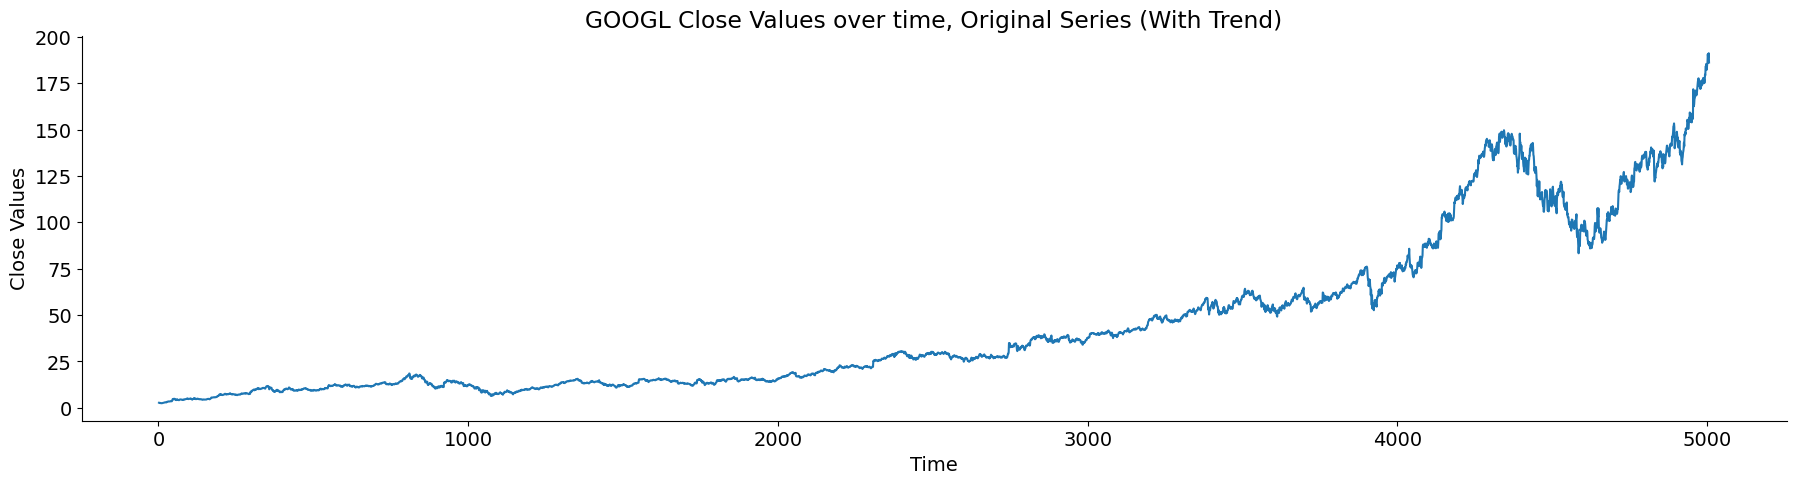

In [22]:
df['Close'].plot()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Time')
plt.ylabel('Close Values')
plt.title(f'{symbol} Close Values over time, Original Series (With Trend)')
plt.show()

We can see there is a trend in the data and we know that ARMA or ARIMA cannot handle trends so we must make it stationary so we can simply do 1 lag of the original series and see if that makes it stationary. Usually we cannot say that 1 or 2 or 3 lags will be enough to make the series stationary. 

It's something that has to be figured out through trial and error.

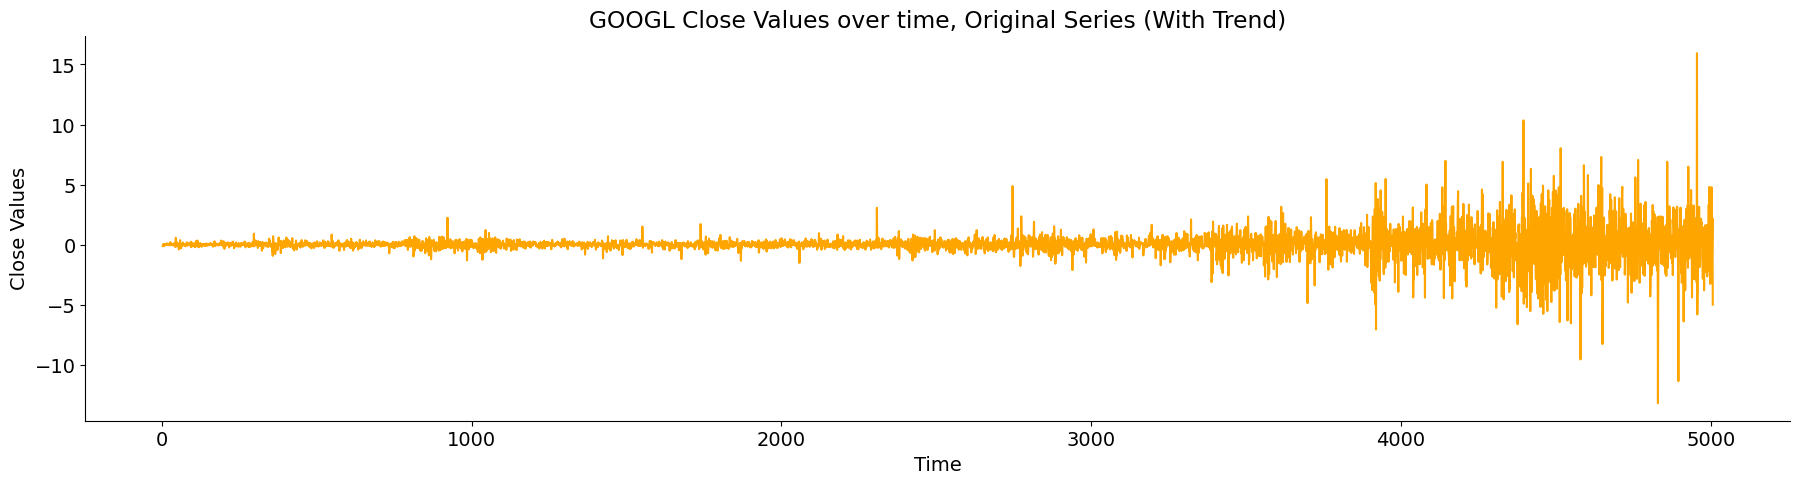

In [23]:
(df['Close'] - df['Close'].shift(1)).plot(color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Time')
plt.ylabel('Close Values')
plt.title(f'{symbol} Close Values over time, Original Series (With Trend)')
plt.show()

It's quite clear now that the series is stationary and we can now train our ARIMA model on this data but wait, what does this mean for the `d` value we have introduced in the ARIMA model.

Well, `d` will be 1 since we have differenced the series 1 time to get to the stationary data hence 1. Had it taken 2 or 3 lags, we would have taken that value as d for ARIMA modelling.

Let's go ahead and fit the model. It's the same procedure with a small change. The second value in the order argument passed to the model will be 1 to tell the model we want differenced series at 1 lag.

In [24]:
exogenous_features = ['Open', 'High', 'Low']
model = ARIMA(df['Close'], order=(1,1,0))
arima_fitted = model.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5005
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7734.546
Date:                Fri, 12 Jul 2024   AIC                          15473.091
Time:                        00:19:29   BIC                          15486.127
Sample:                             0   HQIC                         15477.660
                               - 5005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0541      0.006     -8.374      0.000      -0.067      -0.041
sigma2         1.2885      0.007    174.930      0.000       1.274       1.303
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            114129.84
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              67.66   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
arima_predictions = arima_fitted.predict().to_frame()
arima_predictions['Actual'] = df['Close']
arima_predictions['Date'] = df['Date']
arima_predictions = arima_predictions[['Date', 'Actual', 'predicted_mean']] 
arima_predictions

,Date,Actual,predicted_mean
2,2004-08-23,2.734599,0.000000
3,2004-08-24,2.621365,2.734599
4,2004-08-25,2.649612,2.627491
5,2004-08-26,2.697354,2.648084
6,2004-08-27,2.653361,2.694772
...,...,...,...
5002,2024-07-05,190.600006,185.788633
5003,2024-07-08,189.029999,190.341437
5004,2024-07-09,188.979996,189.114927
5005,2024-07-10,191.179993,188.982701


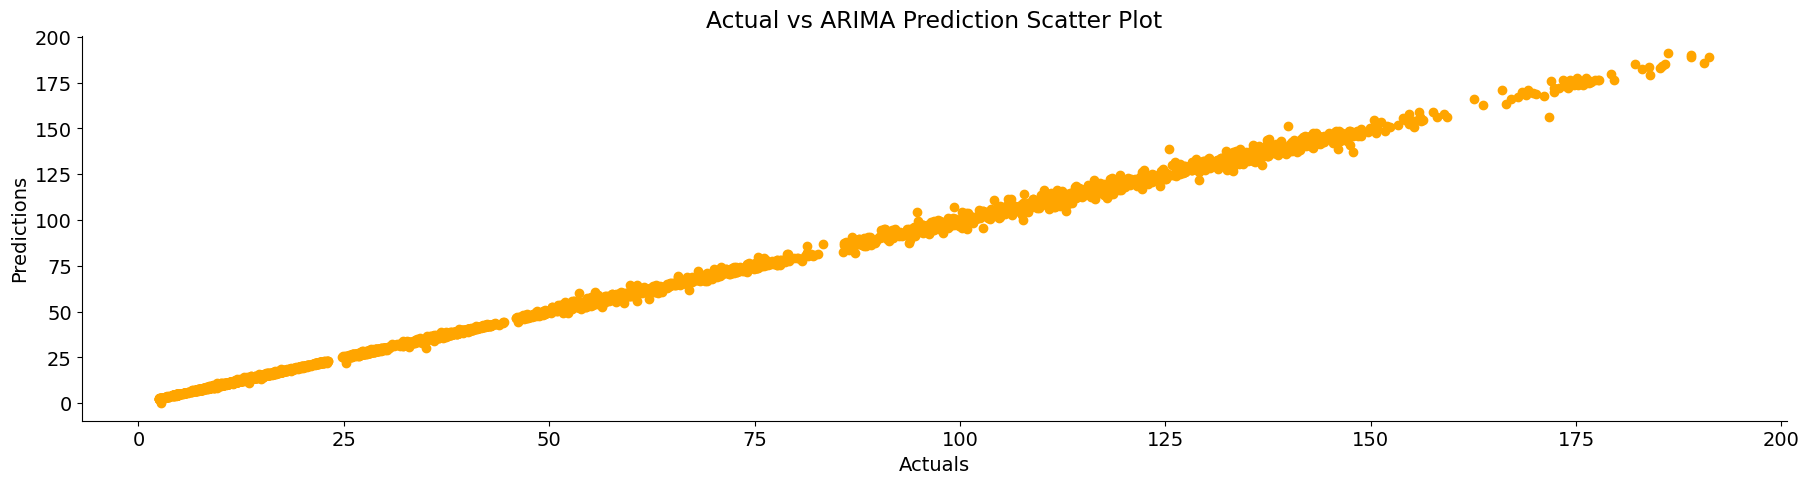

In [27]:
plt.scatter(arima_predictions['Actual'], arima_predictions['predicted_mean'], color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#Set the title, x-axis label, y-axis label, and legend
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.title('Actual vs ARIMA Prediction Scatter Plot')
plt.savefig('ARIMA.jpg')
plt.show()

### Applications of the ARIMA Model

In business and finance, the ARIMA model can be used to forecast future quantities (or even prices) based on historical data. Therefore, for the model to be reliable, the data must be reliable and must show a relatively long time span over which it’s been collected. Some of the applications of the ARIMA model in business are listed below:

- Forecasting the quantity of a good needed for the next time period based on historical data.
- Forecasting sales and interpreting seasonal changes in sales
- Estimating the impact of marketing events, new product launches, and so on.
- ARIMA models can be created in data analytics and data science software like R and Python.

### Limitations of the ARIMA Model

Although ARIMA models can be highly accurate and reliable under the appropriate conditions and data availability, one of the key limitations of the model is that the <text style="background-color : yellow;"> parameters (p, d, q) need to be manually defined ; therefore, finding the most accurate fit can be a long trial-and-error process.<text>

Similarly, the model depends highly on the reliability of historical data and the differencing of the data. It is important to ensure that data was collected accurately and over a long period of time so that the model provides accurate results and forecasts.